# COSC401 Assignment 1
Alex Tompkins (ato47@uclive.ac.nz)

In [237]:
# Global imports
import random
import numpy
import pandas
from matplotlib import pyplot, lines
from sklearn import linear_model, metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from IPython.display import display, HTML, Math

# Set seed for random number generators
SEED = 1337

## 1. Tuning Hyper-parameters

## 2. Decision trees vs linear models

I decided to use a simple linear function as the classifier for my data. This function took the form of $x - y + 4 < 0$, therefore the boundary between the negative and positive classes is along the line $y = x + 4$. 

I then generated a set of 2D data points with a uniform random distribution  between 0 and 20 along both axes. The target set was generated by running the classifier over the data set, as shown below. 

In [238]:
def classifier(x):
    """x - y + 4 < 0"""
    return x[0] - x[1] + 4 < 0


def generate_random_data(max_x1, max_x2, num_points):
    random.seed(SEED)
    data = numpy.asarray([(random.random() * max_x1, random.random() * max_x2) for i in range(num_points)])
    target = numpy.asarray([classifier(pt) for pt in data])
    return data, target


data, target = generate_random_data(20, 20, 2000)

For this part, I used some third-party code to plot decision tree boundaries on the graph as rectangles, provided in an [answer on StackOverflow](https://stackoverflow.com/questions/43929400/retrieve-decision-boundary-lines-x-y-coordinate-format-from-sklearn-decision-t) by user "kazemakase". I have included this code in the cell below, but hidden it for brevity. 

In [239]:
import numpy as np
from collections import deque
from sklearn.tree import _tree as ctree
from matplotlib.patches import Rectangle


class AABB:
    """Axis-aligned bounding box"""

    def __init__(self, n_features):
        self.limits = np.array([[-np.inf, np.inf]] * n_features)

    def split(self, f, v):
        left = AABB(self.limits.shape[0])
        right = AABB(self.limits.shape[0])
        left.limits = self.limits.copy()
        right.limits = self.limits.copy()

        left.limits[f, 1] = v
        right.limits[f, 0] = v

        return left, right


def tree_bounds(tree, n_features=None):
    """Compute final decision rule for each node in tree"""
    if n_features is None:
        n_features = np.max(tree.feature) + 1
    aabbs = [AABB(n_features) for _ in range(tree.node_count)]
    queue = deque([0])
    while queue:
        i = queue.pop()
        l = tree.children_left[i]
        r = tree.children_right[i]
        if l != ctree.TREE_LEAF:
            aabbs[l], aabbs[r] = aabbs[i].split(tree.feature[i], tree.threshold[i])
            queue.extend([l, r])
    return aabbs


def decision_areas(tree_classifier, maxrange, x=0, y=1, n_features=None):
    """ Extract decision areas.

    tree_classifier: Instance of a sklearn.tree.DecisionTreeClassifier
    maxrange: values to insert for [left, right, top, bottom] if the interval is open (+/-inf)
    x: index of the feature that goes on the x axis
    y: index of the feature that goes on the y axis
    n_features: override autodetection of number of features
    """
    tree = tree_classifier.tree_
    aabbs = tree_bounds(tree, n_features)

    rectangles = []
    for i in range(len(aabbs)):
        if tree.children_left[i] != ctree.TREE_LEAF:
            continue
        l = aabbs[i].limits
        r = [l[x, 0], l[x, 1], l[y, 0], l[y, 1], np.argmax(tree.value[i])]
        rectangles.append(r)
    rectangles = np.array(rectangles)
    rectangles[:, [0, 2]] = np.maximum(rectangles[:, [0, 2]], maxrange[0::2])
    rectangles[:, [1, 3]] = np.minimum(rectangles[:, [1, 3]], maxrange[1::2])
    return rectangles


def plot_areas(rectangles):
    for rect in rectangles:
        color = ['r', 'g'][int(rect[4])]
        # print(rect[0], rect[1], rect[2] - rect[0], rect[3] - rect[1])
        rp = Rectangle([rect[0], rect[2]],
                       rect[1] - rect[0],
                       rect[3] - rect[2], color=color, alpha=0.3)
        pyplot.gca().add_artist(rp)


def draw_line(p1, p2, **kwargs):
    ax = pyplot.gca()
    xmin, xmax = ax.get_xbound()

    if p2[0] == p1[0]:
        xmin = xmax = p1[0]
        ymin, ymax = ax.get_ybound()
    else:
        ymax = p1[1] + (p2[1] - p1[1]) / (p2[0] - p1[0]) * (xmax - p1[0])
        ymin = p1[1] + (p2[1] - p1[1]) / (p2[0] - p1[0]) * (xmin - p1[0])

    line = lines.Line2D([xmin, xmax], [ymin, ymax], **kwargs)
    ax.add_line(line)
    return line

From the 2000 data points generated, I put aside 60% for training and 40% for testing. With the training data, I iterated through using different amounts of it (5, 10, 50, 100, 500 and 1000 rows), and for each size iterated through generating decision trees with max depths from 1 to 10:

In [240]:
TRAINING_SIZE_LABEL = 'Training Size'
MAX_DEPTH_LABEL = 'Max Depth'
ACCURACY_LABEL = 'Accuracy'

# Split data into 60% training and 40% testing
X_train, X_test, y_train, y_test = train_test_split(data, target, train_size=0.6, random_state=SEED)
results = []
tree_to_display = None

# Iterate through various training data sizes
for training_size in (5, 10, 50, 100, 500, 1000):
    X_train_resized = X_train[:training_size]
    y_train_resized = y_train[:training_size]

    # Iterate through max tree depths between 1 and 10
    for max_depth in range(1, 10 + 1):
        decision_tree = DecisionTreeClassifier(max_depth=max_depth, random_state=SEED)\
            .fit(X_train_resized, y_train_resized)
        y_predictions = decision_tree.predict(X_test)
        accuracy = accuracy_score(y_test, y_predictions)
        results.append({
            TRAINING_SIZE_LABEL: training_size,
            MAX_DEPTH_LABEL: max_depth,
            ACCURACY_LABEL: accuracy
        })

        if max_depth == 10 and training_size == 1000:
            tree_to_display = decision_tree
            data_to_display = (X_train_resized, y_train_resized)

# Print pivoted table of accuracy for each Max Depth / Training Size combo
data_frame = pandas.DataFrame(results)
pivoted = data_frame.pivot_table(index=MAX_DEPTH_LABEL, columns=TRAINING_SIZE_LABEL)
display(pivoted)

Accuracy                                           
Training Size     5       10      50       100      500      1000
Max Depth                                                        
1              0.67000  0.6700  0.7700  0.75875  0.73500  0.72750
2              0.88375  0.6775  0.8925  0.87875  0.87375  0.88125
3              0.88375  0.6775  0.8925  0.91875  0.90000  0.90625
4              0.88375  0.6775  0.8925  0.93125  0.94625  0.96875
5              0.88375  0.6775  0.8925  0.93125  0.96375  0.97875
6              0.88375  0.6775  0.8925  0.93125  0.95625  0.97625
7              0.88375  0.6775  0.8925  0.93125  0.96875  0.97875
8              0.88375  0.6775  0.8925  0.93125  0.94375  0.98000
9              0.88375  0.6775  0.8925  0.93125  0.94375  0.98000
10             0.88375  0.6775  0.8925  0.93125  0.94375  0.98000

Obviously, higher max depth trees had the ability to fit the data better, and using more training data would allow for a much greater accuracy threshold. 

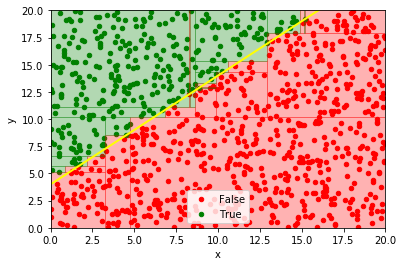

In [241]:
def visualise_data(data, target):
    """Plot randomly generated data (green for positive, red for negative)"""
    colours = {
        True: 'green',
        False: 'red'
    }
    data_frame = pandas.DataFrame(dict(x=data[:, 0], y=data[:, 1], label=target))
    fig, ax = pyplot.subplots()
    grouped = data_frame.groupby('label')
    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colours[key])


visualise_data(*data_to_display)

# Add rectangles to plot to show decision tree boundaries
rectangles = decision_areas(tree_to_display, (0, 20, 0, 20))
plot_areas(rectangles)

# Print number of nodes in the tree
display(HTML(f'<strong>Node count:</strong> {tree_to_display.tree_.node_count}'))

# Add line to chart to show actual classifier
draw_line((0, 4), (16, 20), color='yellow', linewidth=2)

# Show plot
pyplot.xlim(0, 20)
pyplot.ylim(0, 20)
pyplot.show()

In the graph shown above, the yellow line is $y = x + 4$, the actual class boundary. The green and red rectangles show the positive and negative class boundaries respectively for a decision tree classifier fitted using a max depth of 10 and a training size of 1000. 

This example demonstrates the inability of a decision tree to model certain classes of problems. Although a high max depth of 10 and the largest size of training data (1000) was used, the decision tree class boundaries still fail to approximate the actual boundary well, overshooting it at several points. Also, the tree needed a large number of nodes (53) to achieve this. Overfitting is also obvious in certain cases, for example the thin red vertical slice near the middle of the plot, there to fit a single negative data point. 

Using logistic regression or training a perceptron would work well on this problem, as these approaches would be able to approximate the linear function well. However, a decision tree can only make decisions based on one input variable at a time, not a combination of them. Therefore, it produces rectangular class boundaries. For an accurate approximation of the actual class boundaries, the tree requires a large number of nodes (for many small rectangles near the true boundary). 

### Curse of dimensionality
If the data had a large number of dimensions, the number of nodes in the tree would increase considerably. This is because a decision tree can only partition based on one feature at each node, so many more nodes would be required to split on the additional dimensions. 

## 3. Regression on mixed data types

Firstly, we read the data from the CSV file into a pandas DataFrame:

In [242]:
FILENAME = 'assignment1-2019-data.csv'


def read_data_from_csv():
    dataframe = pandas.read_csv(FILENAME)
    return dataframe


dataframe = read_data_from_csv()

### One-hot encoding
Secondly, we must transform the categorical variable X4 into a suitable form. Since the categorical variable has 3 levels, we will use the one hot encoding method to handle it. If we select 'A' to be our base case, we can create two extra "dummy" variables that represent if the value of the categorical variable is 'B' or 'C' respectively. If it is, then that dummy variable is given the value of 1, else 0, as shown below:

In [243]:
# Add dummy variables and interaction terms based on the 3 levels of the categorical variable
# These will also be learned by the model to provide greater accuracy
dataframe['DummyB'] = dataframe['X4'].apply(lambda category: 1 if category == 'B' else 0)
dataframe['DummyC'] = dataframe['X4'].apply(lambda category: 1 if category == 'C' else 0)
display(dataframe[['X4', 'DummyB', 'DummyC']][1:4])

,X4,DummyB,DummyC
1,A,0,0
2,C,0,1
3,B,1,0


### Interaction terms
When the model is fitted, the coefficients of these dummy variables will give us the "difference" in the intercept for data of categories B and C compared to the base case. However, when we construct the final piecewise function identified by the regression model, we also want to use different coefficients on the other input features (X1, X2, X3) depending on the value of the categorical feature (X4). Essentially, this means we will be fitting three variants of the function, one for each value of X4. 

To do this, we can introduce interaction terms. For each of our other input features, we can add new features which are those variables multiplied by our dummy variables, as seen below (X1B, X1C, X2B, ...):

In [244]:
for col in ('X1', 'X2', 'X3'):
    dataframe[f'{col}B'] = dataframe[col] * dataframe['DummyB']
    dataframe[f'{col}C'] = dataframe[col] * dataframe['DummyC']
display(dataframe[:10])

,X1,X2,X3,X4,Y,DummyB,DummyC,X1B,X1C,X2B,X2C,X3B,X3C
0,3.342,-0.354,7.925,A,37.892,0,0,0.000,0.000,-0.000,-0.000,0.000,0.000
1,5.032,-0.605,2.842,A,31.875,0,0,0.000,0.000,-0.000,-0.000,0.000,0.000
2,1.026,-0.221,4.180,C,24.818,0,1,0.000,1.026,-0.000,-0.221,0.000,4.180
3,3.373,2.510,4.103,B,19.307,1,0,3.373,0.000,2.510,0.000,4.103,0.000
4,1.210,-0.624,9.783,B,20.506,1,0,1.210,0.000,-0.624,-0.000,9.783,0.000
5,3.526,-0.171,5.488,A,33.594,0,0,0.000,0.000,-0.000,-0.000,0.000,0.000
6,0.980,0.782,4.386,C,25.337,0,1,0.000,0.980,0.000,0.782,0.000,4.386
7,3.869,-2.096,10.930,B,22.729,1,0,3.869,0.000,-2.096,-0.000,10.930,0.000
8,1.197,-2.968,5.169,C,3.541,0,1,0.000,1.197,-0.000,-2.968,0.000,5.169
9,2.415,1.374,4.655,C,24.195,0,1,0.000,2.415,0.000,1.374,0.000,4.655


Once we have our dummy variables and interaction terms added, we can fit the linear regression model, which will give us the coefficients for each variable:

In [245]:
# Carry out linear regression to find coefficients and intercept
x = dataframe[[col for col in dataframe if col not in ('X4', 'Y')]]
y = dataframe['Y']
regression = linear_model.LinearRegression().fit(x, y)
coeffs = {x.columns.values[i]: coeff for i, coeff in enumerate(regression.coef_)}
intercept = regression.intercept_

# Display the learned coefficients (both unrounded and rounded versions)
display(HTML('<strong>Coefficients of the learned model</strong>'))

fitted_coeffs = pandas.DataFrame({key: [value] for key, value in coeffs.items()})
fitted_coeffs['Intercept'] = [intercept]
display(HTML('Unrounded:'))
display(HTML(fitted_coeffs.to_html(index=False)))

rounded_coeffs = pandas.DataFrame({key: [int(round(value))] for key, value in coeffs.items()})
rounded_coeffs['Intercept'] = [int(round(intercept))]
display(HTML('Rounded:'))
display(HTML(rounded_coeffs.to_html(index=False)))

X1,X2,X3,DummyB,DummyC,X1B,X1C,X2B,X2C,X3B,X3C,Intercept
3.792788,0.973181,2.941037,5.542313,8.621741,-1.960825,-6.618655,-0.987043,5.841475,-1.950099,0.042355,3.04398


X1,X2,X3,DummyB,DummyC,X1B,X1C,X2B,X2C,X3B,X3C,Intercept
4,1,3,6,9,-2,-7,-1,6,-2,0,3


We can use these coefficients to define the piecewise function we will use for prediction. The weights on each of the features X1, X2, and X3 will be the coefficient for that feature plus the interaction term for that level of the categorical variable X4, i.e.

$$
y = \left\{
        \begin{array}{ll}
            w_{1,1} x_1 + w_{1,2} x_2 + w_{1,3} x_3 + b_1   & \quad c = l_1 \\
            w_{2,1} x_1 + w_{2,2} x_2 + w_{2,3} x_3 + b_2   & \quad c = l_2 \\
            w_{3,1} x_1 + w_{3,2} x_2 + w_{3,3} x_3 + b_3   & \quad c = l_3
        \end{array}
    \right.
$$

becomes

$$
y = \left\{
        \begin{array}{ll}
            k_{X1} x_1 + k_{X2} x_2 + k_{X3} x_3 + intercept    & \quad c = l_1 \\
            (k_{X1} + k_{X1B}) x_1 + (k_{X2} + k_{X2B}) x_2 + (k_{X3} + k_{X3B}) x_3 + (intercept + k_{DummyB})    & \quad c = l_2 \\
            (k_{X1} + k_{X1C}) x_1 + (k_{X2} + k_{X2C}) x_2 + (k_{X3} + k_{X3C}) x_3 + (intercept + k_{DummyC})    & \quad c = l_3
        \end{array}
    \right.
$$

In [246]:
def create_piecewise_function(c, intercept):
    """
    Creates the piecewise function identified by the regression model. This function will have different weights for
    each input variable based on the value of the categorical variable.
    :param c: The learned coefficients of each input variable
    :param intercept: The y-intercept of the learned model
    :return: The piecewise function learned by the regression model
    """
    weights = numpy.array([
        [c['X1'], c['X2'], c['X3'], intercept],
        [c['X1'] + c['X1B'], c['X2'] + c['X2B'], c['X3'] + c['X3B'], intercept + c['DummyB']],
        [c['X1'] + c['X1C'], c['X2'] + c['X2C'], c['X3'] + c['X3C'], intercept + c['DummyC']]
    ])

    def predict(row):
        weight_map = {
            'A': weights[0],
            'B': weights[1],
            'C': weights[2]
        }
        coeffs = weight_map[row['X4']]
        return coeffs[0] * row['X1'] + coeffs[1] * row['X2'] + coeffs[2] * row['X3'] + coeffs[3]

    return predict, weights


predict, weights = create_piecewise_function(coeffs, intercept)
predictions = dataframe[['X1', 'X2', 'X3', 'X4']].apply(predict, axis=1)
mean_sq_error = metrics.mean_squared_error(y, predictions)
r_squared_score = metrics.r2_score(y, predictions)

print(f'Weights:\n{weights}')
print(f'Mean Squared Error: {mean_sq_error:.4f}\n'
      f'R^2 score: {r_squared_score:.4f}')

Weights:
[[ 3.79278836  0.97318107  2.94103693  3.04397961]
 [ 1.83196342 -0.01386211  0.99093824  8.58629311]
 [-2.82586671  6.81465584  2.98339219 11.66572083]]
Mean Squared Error: 6.7002
R^2 score: 0.9549


If we create the piecewise function (using the unrounded coefficients) to make predictions on the dataset we just trained it from, we get the above values for mean squared error and $R^2$.

In [247]:
rounded = {key: int(round(value)) for key, value in coeffs.items()}
predict, weights = create_piecewise_function(rounded, int(round(intercept)))
print(f'Weights from rounded coefficients:\n{weights}')

Weights from rounded coefficients:
[[ 4  1  3  3]
 [ 2  0  1  9]
 [-3  7  3 12]]


### Defining the learned model with rounded coefficients
Rounding the coefficients of the learned model and using these to write a case-based definition of the function gives the following:

$$
y = \left\{
        \begin{array}{ll}
            4 x_1 + 1 x_2 + 3 x_3 + 3   & \quad c = l_1 \\
            2 x_1 + 0 x_2 + 1 x_3 + 9   & \quad c = l_2 \\
            -3 x_1 + 7 x_2 + 3 x_3 + 12   & \quad c = l_3
        \end{array}
    \right.
$$

### Making new predictions
To make a prediction on a previously unseen data point, we would first determine which part of the piecewise function to use by checking the value of X4, the categorical variable. Once we have selected the appropriate part of the function for that value, we would simply substitute X1, X2, and X3 into that part to give us a Y prediction. 

## References

1. https://blog.waylay.io/the-curse-of-dimensionality-in-decision-trees-branching-problem/
2. https://stackoverflow.com/questions/43929400/retrieve-decision-boundary-lines-x-y-coordinate-format-from-sklearn-decision-t